In [1]:
# !pip install scikit-uplift
# !pip install causalml

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import uplift_at_k, uplift_curve, response_rate_by_percentile, uplift_by_percentile
from sklift.viz import plot_uplift_preds, plot_uplift_curve

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot, uplift_tree_string

from IPython.display import Image, display
%matplotlib inline

## Data description
recency
* sort months since last purchase

history
* sort value of the historical purchases

used_discount
* sort indicates if the customer used a discount before

used_bogo
* sort indicates if the customer used a buy one get one before

zip_code
* sort class of the zip code as Suburban/Urban/Rural

is_referral
* sort indicates if the customer was acquired from referral channel

channel
* sort channels that the customer using, Phone/Web/Multichannel

offer
* sort the offers sent to the customers, Discount/But One Get One/No Offer

conversion
* sort customer conversion(buy or not)

In [3]:
df = pd.read_csv('HW_data.csv')

In [4]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
df_copy = df.copy()

In [116]:
df.conversion.value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

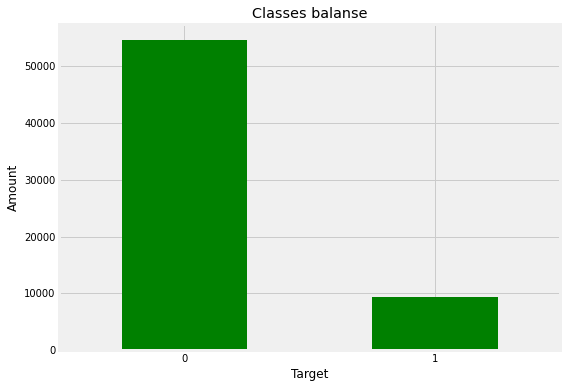

In [6]:
# дисбаланс классов
df.conversion.value_counts().plot(kind='bar',figsize=(8, 6), color='green')
plt.title('Classes balanse')
plt.ylabel('Amount')
plt.xlabel('Target')
plt.xticks(rotation=0);

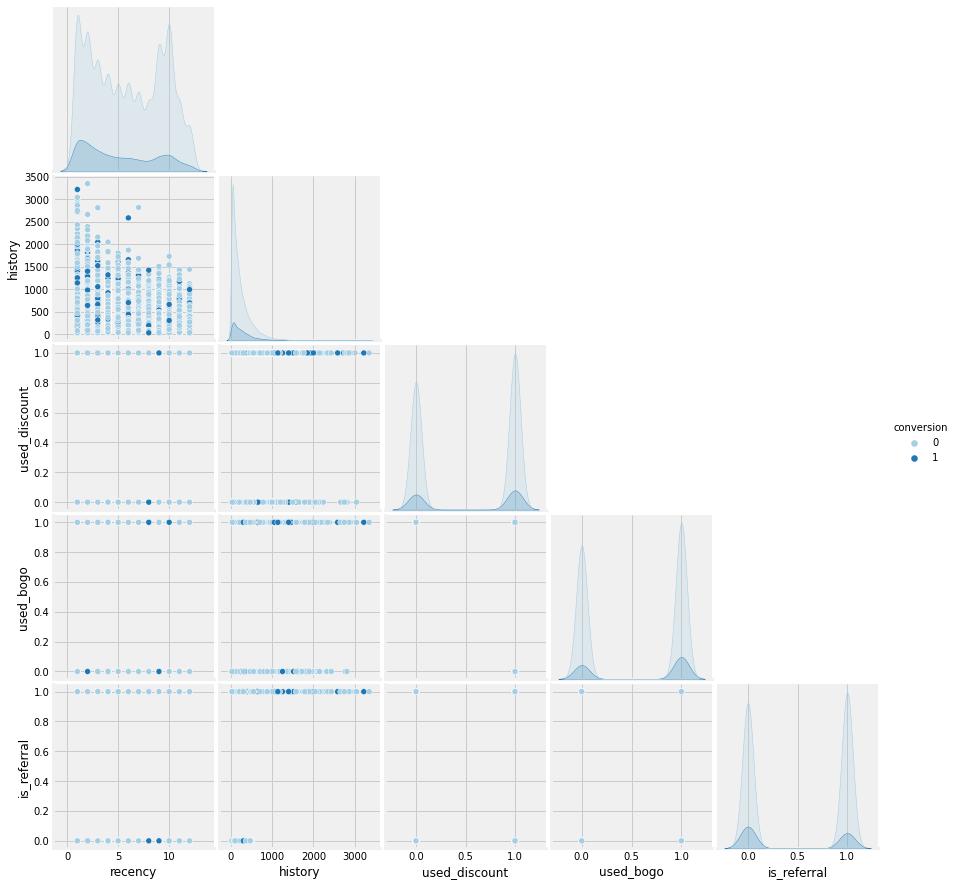

In [7]:
sns.pairplot(df, hue='conversion',corner=True)

<AxesSubplot:>

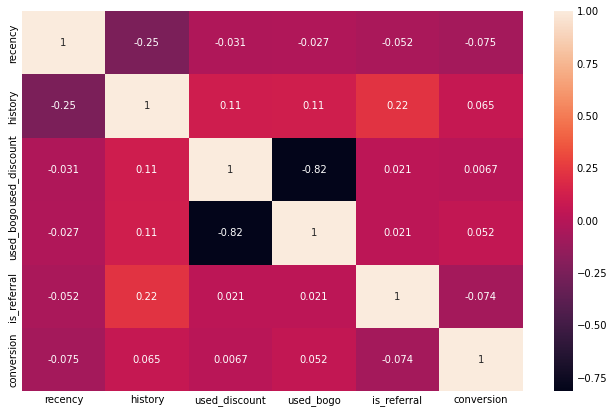

In [9]:
# отрицательная корреляция между used_discount и used_bogo
corr = df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True)

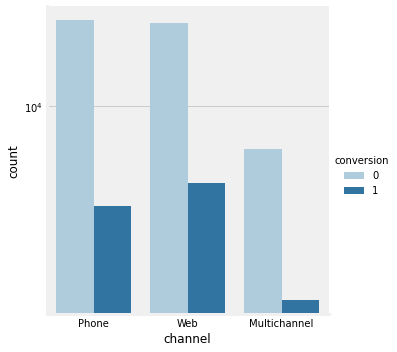

In [33]:
sns.catplot(data=df, x='channel', hue='conversion', kind='count')
plt.yscale('log')

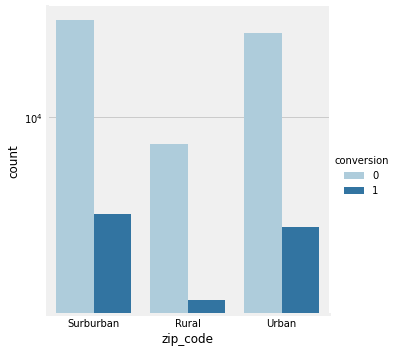

In [34]:
sns.catplot(data=df, x='zip_code', hue='conversion', kind='count')
plt.yscale('log')

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [36]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [6]:
train, test = train_test_split(df, test_size=0.25, random_state=42)

In [7]:
class DataPreprocessing:
    
    def __init__(self, data, rename_dict, encoder, scaler=False, test=False):
        self.df = data
        self.rename_dict = rename_dict
        self.encoder = encoder
        self.scaler = scaler
        self.test = test
        
    def correct_data(self):
        # binarize offer
        self.df.offer = np.where(self.df.offer == 'No Offer', 0, 1)
        # rename columns
        self.df.rename(columns=self.rename_dict, inplace=True)
        # encode categores
        non_numerical = self.df.select_dtypes('object').columns
        dummies = pd.get_dummies(self.df[non_numerical])
        self.df = pd.concat([self.df, dummies], axis=1)
        self.df.drop(non_numerical, axis=1, inplace=True)
        
            
        if self.scaler:
            columns = ['recency', 'history']   
            for el in columns:   
                self.df[el] = self.scaler().fit_transform(self.df[el].values.reshape(-1, 1))
                    
        features, target, treatment = self.df.drop(['target', 'treatment', 'zip_code_Surburban', 'zip_code_Urban', 
                                                   'channel_Phone', 'channel_Web'], axis=1), self.df.target, self.df.treatment           
            
        return features, target, treatment
            

In [8]:
train_transformer = DataPreprocessing(train,
                                {'offer':'treatment', 'conversion':'target' },
                                OneHotEncoder)
X_train, y_train, treat_train = train_transformer.correct_data()

In [9]:
test_transformer = DataPreprocessing(test,
                                {'offer':'treatment', 'conversion':'target' },
                                OneHotEncoder)
X_test, y_test, treat_test = test_transformer.correct_data()

In [148]:
results = {'model':[],
          'uplift 10%':[],
          'uplift 20%':[]}

##  Проверка гипотез

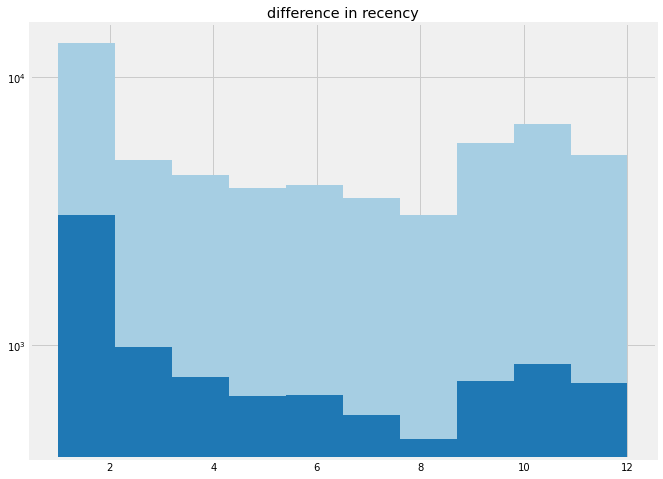

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('difference in recency')
plt.hist(X.recency[X.target == 0])
plt.hist(X.recency[X.target == 1])
plt.yscale('log')

In [50]:
def show_cross_target(data, title, scale=False):
    crosstab = pd.crosstab(df.target, data)
    crosstab.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.ylabel('Amount')
    plt.xlabel('Target')
    plt.xticks(rotation=0)
    if scale:
        plt.yscale('log')
    return crosstab


1.2098080358777079e-78

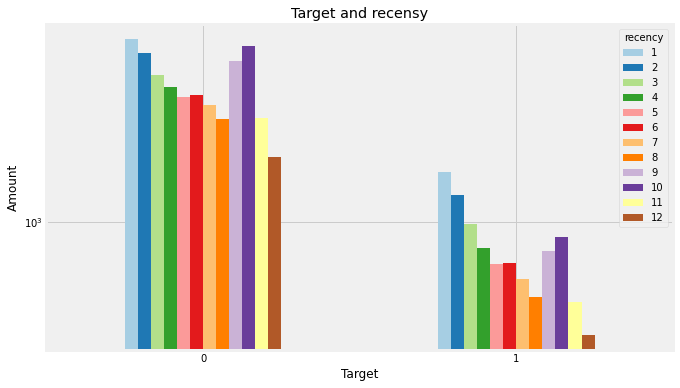

In [53]:
# alpha = 0.05 Графики похожи, но статистические резличия присутствуют
recensy = show_cross_target(df.recency, 'Target and recensy', scale=True)
chi, p, dop, expected = chi2_contingency(recensy)
p

1.8506024687525873e-39

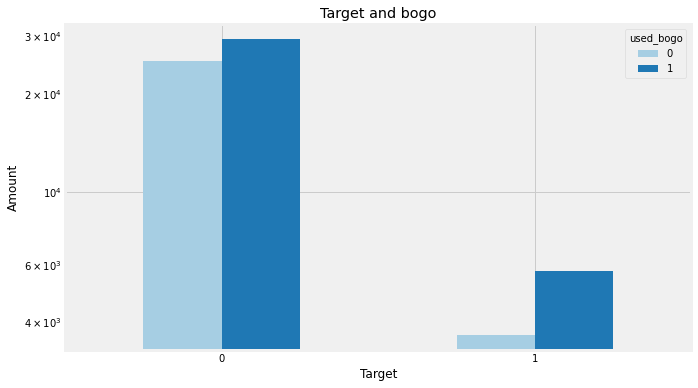

In [56]:
# статистические различия наяву 
# в группе с воздействием больше людей, принимавших участие в buy one get one раньше
# возможно, это особенность выборки
bogo = show_cross_target(df.used_bogo, 'Target and bogo', scale=True)
chi, p, dop, expected = chi2_contingency(bogo)
p

0.0916443416336384

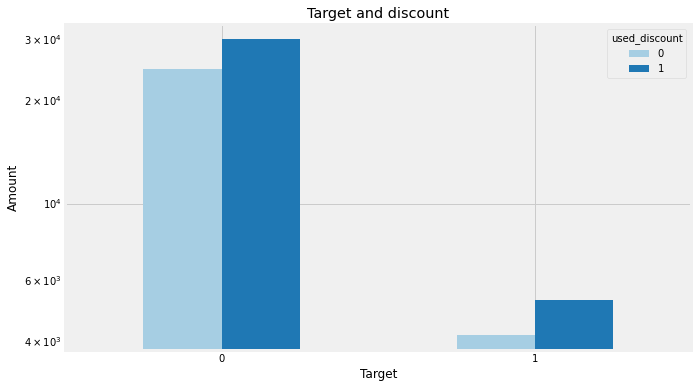

In [58]:
# при alpha 0.05 статистических различий не выявлено
# тут спорно,судя по графику, но примем на веру, признак можно будет убрать
discount = show_cross_target(df.used_discount, 'Target and discount', scale=True)
chi, p, dop, expected = chi2_contingency(discount)
p

1.2736921440078863e-35

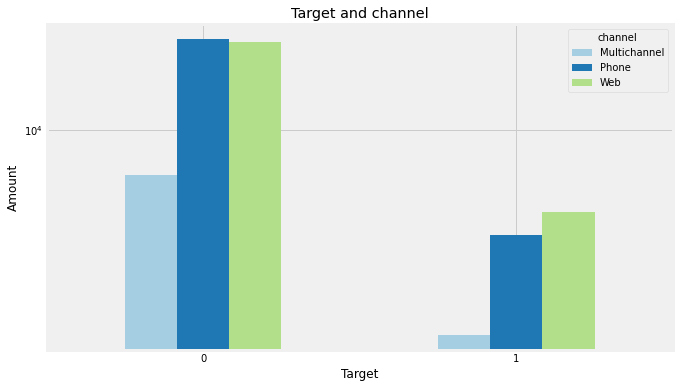

In [59]:
# здесь мало выводов для модели, но на будущее - в целевой группе мало
# людей, которым отправляли уведомления по нескольким каналам, 
# а не в целевой их куда больше
# вывод - этого делать явно не стоит, достаточно одного канала
# можно поэкспериментировать и оставить только  multichannel. 
channel = show_cross_target(df.channel, 'Target and channel', scale=True)
chi, p, dop, expected = chi2_contingency(channel)
p

4.636935563366961e-34

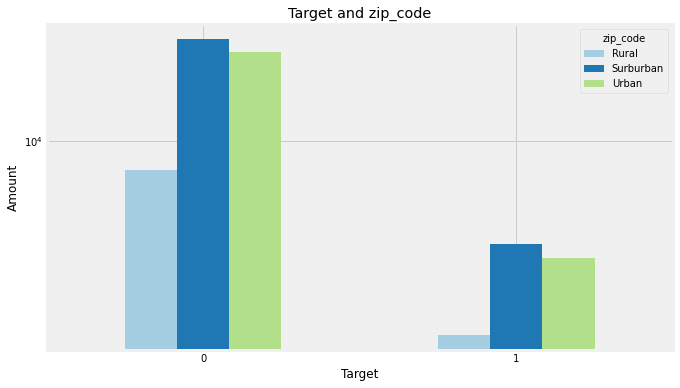

In [60]:
# похожая картина, можно выкинуть все, кроме rural
code = show_cross_target(df.zip_code, 'Target and zip_code', scale=True)
chi, p, dop, expected = chi2_contingency(code)
p

5.9404293217102945e-78

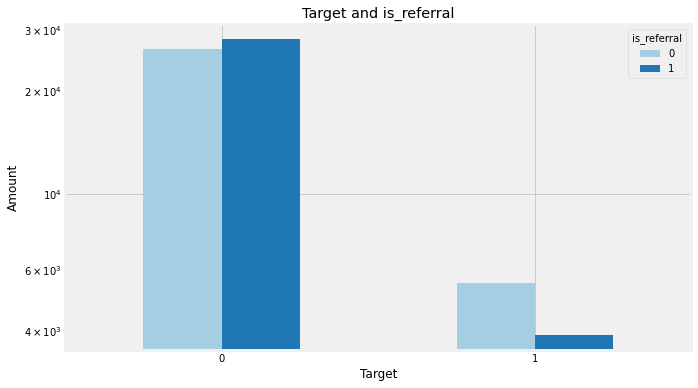

In [63]:
is_referral = show_cross_target(df.is_referral, 'Target and is_referral', scale=True)
chi, p, dop, expected = chi2_contingency(is_referral)
p

## Solomodel

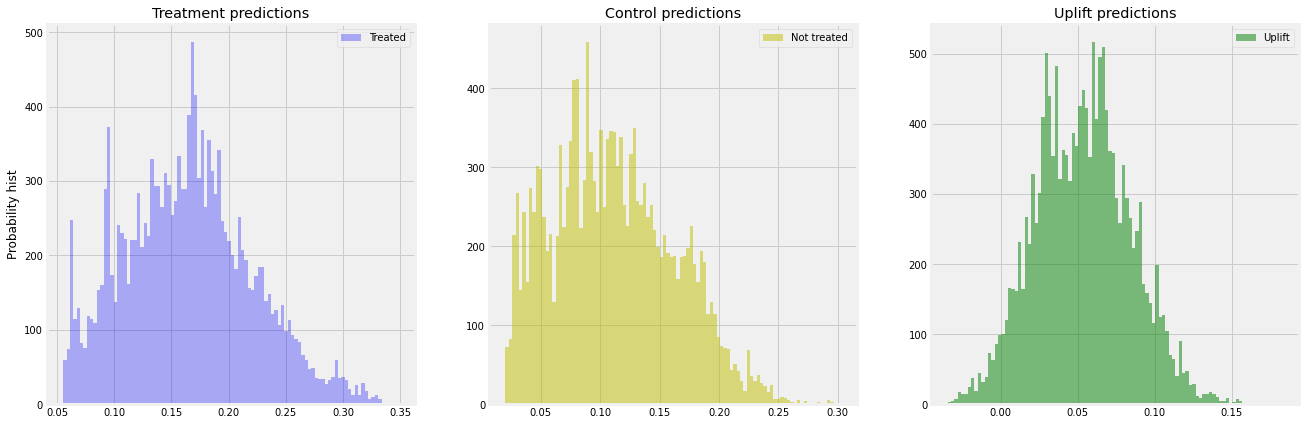

In [149]:
# k=0.1
solo = SoloModel(RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_leaf=50,random_state=42))
solo.fit(X_train, y_train, treat_train)

solo_preds = solo.predict(X_test)
solo_score = uplift_at_k(y_true=y_test, uplift=solo_preds, treatment=treat_test, strategy='by_group', k=0.1)

results['model'].append('SoloModel')
results['uplift 10%'].append(solo_score)

solo_treat = solo.trmnt_preds_
solo_nontreat = solo.ctrl_preds_
plot_uplift_preds(trmnt_preds=solo_treat, ctrl_preds=solo_nontreat);

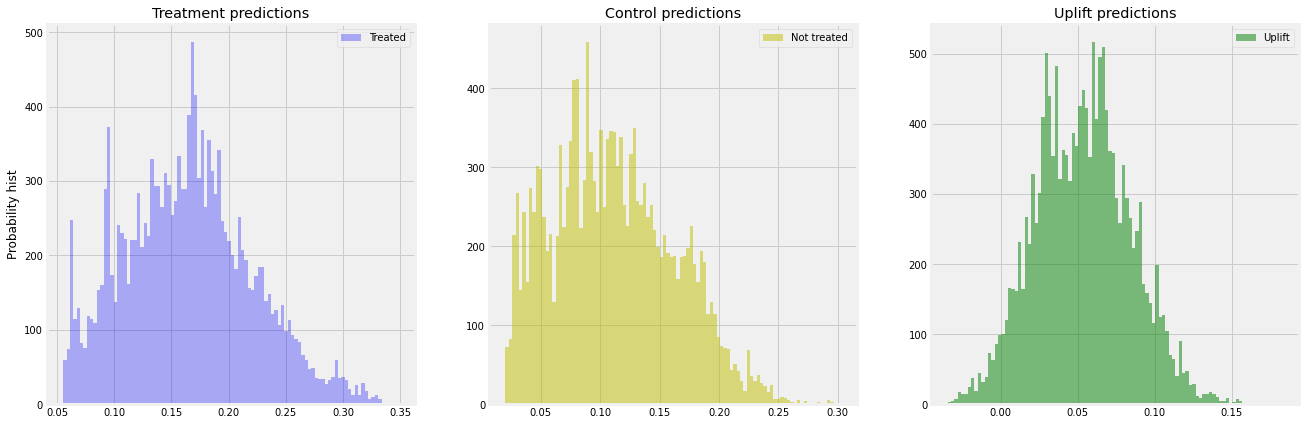

In [150]:
# k = 0.2
solo = SoloModel(RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_leaf=50,random_state=42))
solo.fit(X_train, y_train, treat_train)

solo_preds = solo.predict(X_test)
solo_score = uplift_at_k(y_true=y_test, uplift=solo_preds, treatment=treat_test, strategy='by_group', k=0.2)


results['uplift 20%'].append(solo_score)

solo_treat = solo.trmnt_preds_
solo_nontreat = solo.ctrl_preds_
plot_uplift_preds(trmnt_preds=solo_treat, ctrl_preds=solo_nontreat);

In [151]:
results

{'model': ['SoloModel'],
 'uplift 10%': [0.11725809851732133],
 'uplift 20%': [0.09546450222341235]}

In [152]:
features = pd.DataFrame({'features': solo.estimator.feature_names_in_,
                        'importance': solo.estimator.feature_importances_})
features.sort_values('importance',ascending=False)

,features,importance
1,history,0.359799
0,recency,0.195483
4,is_referral,0.133124
7,treatment,0.123639
3,used_bogo,0.065433
2,used_discount,0.057916
5,zip_code_Rural,0.051240
6,channel_Multichannel,0.013366


## ClassTransformation

In [153]:
# k = 0.1
transformation = ClassTransformation(RandomForestClassifier(max_depth=10,
                                                           n_estimators=200,
                                                           min_samples_leaf=50,
                                                           random_state=42))
transformation.fit(X_train, y_train, treat_train)

transformation_preds = transformation.predict(X_test)

transformation_score = uplift_at_k(y_true=y_test, uplift=transformation_preds,
                                  treatment=treat_test, strategy='by_group',
                                  k=0.1)
results['model'].append('ClassTransformation')
results['uplift 10%'].append(transformation_score)

In [154]:
# k = 0.2
transformation = ClassTransformation(RandomForestClassifier(max_depth=10,
                                                           n_estimators=200,
                                                           min_samples_leaf=50,
                                                           random_state=42))
transformation.fit(X_train, y_train, treat_train)

transformation_preds = transformation.predict(X_test)

transformation_score = uplift_at_k(y_true=y_test, uplift=transformation_preds,
                                  treatment=treat_test, strategy='by_group',
                                  k=0.2)
results['uplift 20%'].append(transformation_score)

In [155]:
features = pd.DataFrame({'features': transformation.estimator.feature_names_in_,
                        'importance': transformation.estimator.feature_importances_})
features.sort_values('importance',ascending=False)

,features,importance
1,history,0.634563
0,recency,0.206917
3,used_bogo,0.046152
4,is_referral,0.037621
2,used_discount,0.030735
5,zip_code_Rural,0.024370
6,channel_Multichannel,0.019642


In [156]:
results

{'model': ['SoloModel', 'ClassTransformation'],
 'uplift 10%': [0.11725809851732133, 0.08834410793338487],
 'uplift 20%': [0.09546450222341235, 0.08385710460353901]}

## TwoModels

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

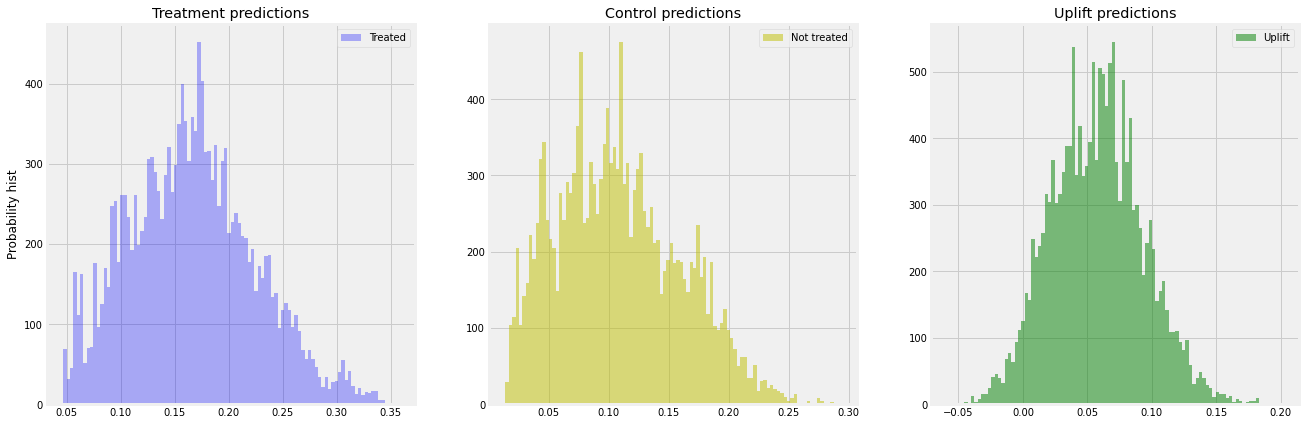

In [157]:
# k = 0.1
twomodels = TwoModels(RandomForestClassifier(max_depth=10, n_estimators=200,
                                            random_state=42, min_samples_leaf=50),
                      RandomForestClassifier(max_depth=10, n_estimators=200,
                                            random_state=42, min_samples_leaf=50)
                     )
twomodels.fit(X_train, y_train, treat_train)
twomodels_preds = twomodels.predict(X_test)

twomodels_score = uplift_at_k(y_true=y_test, uplift=twomodels_preds,
                              treatment=treat_test, strategy='by_group',
                             k=0.1)
results['model'].append('TwoModels')
results['uplift 10%'].append(twomodels_score)

two_treat = twomodels.trmnt_preds_
two_nontreat = twomodels.ctrl_preds_

plot_uplift_preds(two_treat, two_nontreat)

array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

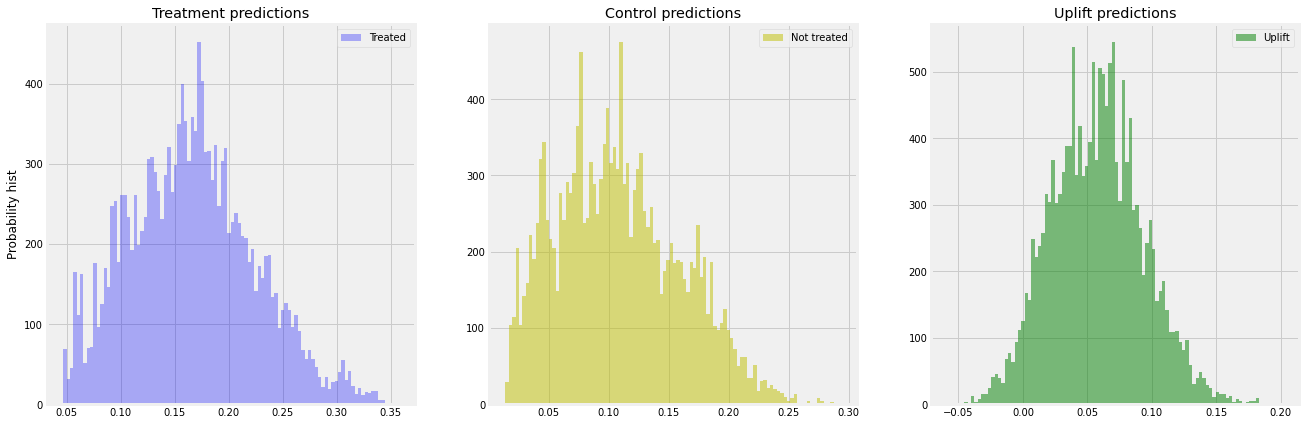

In [158]:
# k = 0.2
twomodels = TwoModels(RandomForestClassifier(max_depth=10, n_estimators=200,
                                            random_state=42, min_samples_leaf=50),
                      RandomForestClassifier(max_depth=10, n_estimators=200,
                                            random_state=42, min_samples_leaf=50)
                     )
twomodels.fit(X_train, y_train, treat_train)
twomodels_preds = twomodels.predict(X_test)

twomodels_score = uplift_at_k(y_true=y_test, uplift=twomodels_preds,
                              treatment=treat_test, strategy='by_group',
                             k=0.2)

results['uplift 20%'].append(twomodels_score)

two_treat = twomodels.trmnt_preds_
two_nontreat = twomodels.ctrl_preds_

plot_uplift_preds(two_treat, two_nontreat)

In [ ]:
# на k=0.1 лучше отрабатывает solomodel, на k=0.2 - twomodels
# возможно есть смысл пропустить все через grid_search
# но ресурсы наши малы(
# трансформация данных в любом случае хуже себя показывает в обоих случаях 

# в feature ingenering фантазии хватило только поудалять лишнее,
# если есть возможность, пришлите разбор решений

In [160]:
pd.DataFrame({'model': results['model'],'uplift 10%':results['uplift 10%']}).sort_values('uplift 10%', ascending=False)

,model,uplift 10%
0,SoloModel,0.117258
2,TwoModels,0.104100
1,ClassTransformation,0.088344


In [161]:
pd.DataFrame({'model': results['model'],'uplift 20%':results['uplift 20%']}).sort_values('uplift 20%', ascending=False)

,model,uplift 20%
2,TwoModels,0.105774
0,SoloModel,0.095465
1,ClassTransformation,0.083857


In [91]:
# pd.DataFrame({'model': results['model'],'uplift 10%':results['uplift 10%']}).sort_values('uplift 10%', ascending=False)

#     model	            uplift 10%
# 0	SoloModel           0.109623
# 2	TwoModels           0.099422
# 1	ClassTransformation	0.073285


In [92]:
# pd.DataFrame({'model': results['model'],'uplift 20%':results['uplift 20%']}).sort_values('uplift 20%', ascending=False)

#     model                uplift 20%
# 0	SoloModel           0.090753
# 1	ClassTransformation 0.089939
# 2	TwoModels           0.069272


In [ ]:
# Это, результаты, полученные до проверки гипотез, и они в обоих почти одинаковые
# Либо здесь есть ошибка, либо аналитик из меня так-себе
# В обеих случаях лучше всего показала себя SoloModel
# возможно причина в дисбалансе классов,
# который мешает жить ClassTrasformation модели

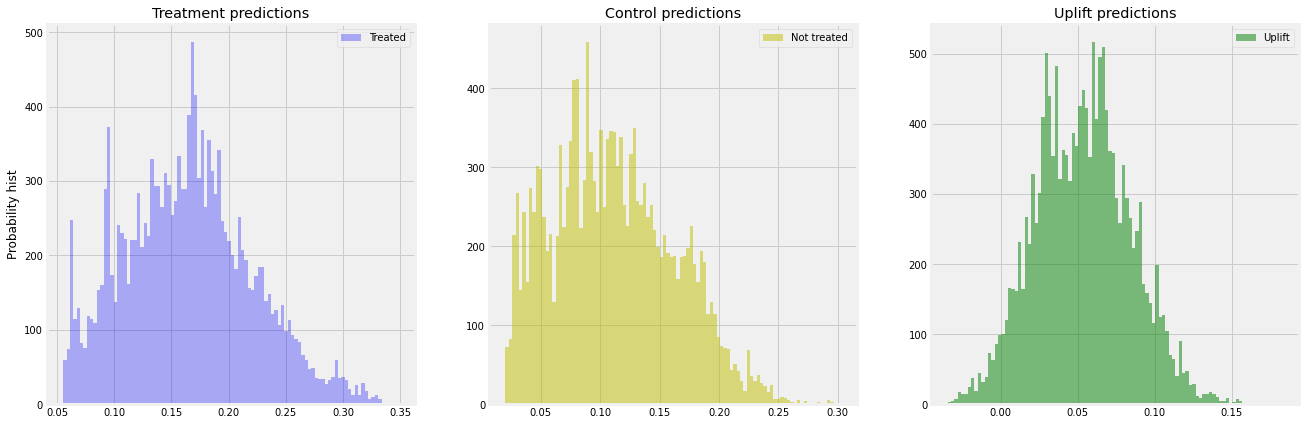

In [162]:
# (опционально) для модели S learner (модель с дополнительным признаком коммуникации) 
# построить зависимость таргета (конверсии - поле conversion) от значения uplift: 
# 1) сделать прогноз и получить uplift для тестовой выборки 
# 2) отсортировать тестовую выборку по uplift по убыванию 
# 3) разбить на децили (pandas qcut вам в помощь) 
# 4) для каждого дециля посчитать среднюю conversion

# k = 0.2
solo = SoloModel(RandomForestClassifier(max_depth=10, n_estimators=200,min_samples_leaf=50,random_state=42))
solo.fit(X_train, y_train, treat_train)

solo_preds = solo.predict(X_test)
solo_score = uplift_at_k(y_true=y_test, uplift=solo_preds, treatment=treat_test, strategy='by_group', k=0.2)


results['uplift 20%'].append(solo_score)

solo_treat = solo.trmnt_preds_
solo_nontreat = solo.ctrl_preds_
plot_uplift_preds(trmnt_preds=solo_treat, ctrl_preds=solo_nontreat);

In [169]:
# Ну такое. Сложно вывести закономерность зависимости таргета от uplift 
# надоело все валить на дисбаланс классов, но я не могу другое обьяснение придумать
pd.DataFrame({"treat": treat_test[:20],
              'uplift 20%': solo_preds[:20],
             'target': y_test[:20]}).sort_values('uplift 20%')

,treat,uplift 20%,target
25383,1,-0.018495,0
26195,0,0.021044,0
7168,0,0.021303,0
39119,1,0.021705,0
33042,1,0.031168,0
57052,1,0.041586,1
22573,1,0.049999,0
36096,0,0.054009,0
38387,0,0.059195,0
28098,0,0.059943,0


In [172]:
uplift_by_percentile(y_test, solo_preds, treat_test, total=True, std=True)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift,std_treatment,std_control,std_uplift
percentile,,,,,,,,
0-10,1071,529,0.242764,0.126654,0.116110,0.013101,0.014460,0.019513
10-20,1091,509,0.175069,0.094303,0.080766,0.011505,0.012954,0.017325
20-30,1062,538,0.181733,0.102230,0.079502,0.011833,0.013061,0.017624
30-40,1057,543,0.154210,0.092081,0.062129,0.011108,0.012408,0.016654
40-50,1061,539,0.151744,0.094620,0.057124,0.011014,0.012607,0.016741
50-60,1079,521,0.156627,0.092131,0.064496,0.011065,0.012671,0.016822
60-70,1028,572,0.143969,0.094406,0.049563,0.010949,0.012226,0.016412
70-80,1093,507,0.136322,0.090730,0.045592,0.010379,0.012756,0.016445
80-90,1059,541,0.153919,0.094270,0.059649,0.011089,0.012563,0.016757


In [10]:
# (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [63]:
uplift_model = UpliftRandomForestClassifier(control_name='control',max_depth=7, n_estimators=50, min_samples_leaf=150,min_samples_treatment=50, random_state=42)


uplift_model.fit(X_train.values,
                  treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train.values)

In [75]:
uplift_tree = uplift_model.uplift_forest[2]
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, [i for i in X_train])

In [77]:
# как не крутила, так и не визуализировалось. Что с этим делать?
graph.create_png()

InvocationException: GraphViz's executables not found